In [160]:
import emcee
import pandas as pd
import numpy as np
from scipy import stats
import chainconsumer 
import matplotlib.pyplot as plt
from scipy.integrate import quad
from chainconsumer import ChainConsumer
plt.rc('font', size=15)          # controls default text sizes
plt.rc('axes', titlesize=15)     # fontsize of the axes title
plt.rc('axes', labelsize=15)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize
%config InlineBackend.figure_format = 'svg'

#constants

import corner

# standard deviation of proposed step
sigma=0.01

# number of MCMC steps
Nsteps=10000

# plot asthetics 
#plt.rcParams['figure.figsize'] = [20, 12]  # set plotsize
#plt.rcParams.update({'font.size': 22})       # set fontsize

In [161]:
data_pd = pd.read_csv("hlsp_ps1cosmo_panstarrs_gpc1_all_model_v1_lcparam-full.txt",sep=' ',usecols=[0,1,2,3,4,5])
z = data_pd['zhel'].astype(np.float)
dz = data_pd['dz'].astype(np.float)
muB = data_pd['mb'].astype(np.float)
dmuB = data_pd['dmb'].astype(np.float)

data = {}
data['z'] = z
data['dz'] = dz
data['muB'] = muB
data['dmuB'] = dmuB

In [162]:
def get_default_parameters(update=None):
    pars = {}
    pars['omega_m'] = 0.3
    pars['omega_L'] = 0.7
    pars['omega_K'] = 0.0
    pars['h'] = 0.72
    pars['w'] = -1.
    if update is not None:
        pars.update(update)
    return pars

def get_starting_point(name_list):
    sp = {}
    sp['omega_m'] = 0.24
    sp['omega_L'] = 0.74
    sp['omega_K'] = 0.0
    sp['h'] = 0.65
    sp['w'] = -1.    
    return np.array([sp[x] for x in name_list])

def get_latex_names(name_list):
    latex_names = {}
    latex_names['omega_m'] = '$\Omega_m$'
    latex_names['omega_L'] = '$\Omega_L$'
    latex_names['omega_K'] = '$\Omega_K$'
    latex_names['h'] = 'h'
    latex_names['w'] = '$w$'
    
    return [latex_names[x] for x in name_list]
#constraints on the parameter values
parameter_limits={
    'omega_m' : [0., 1.],
    'omega_L' : [0., 1.],
    'omega_K' : [0., 0.], #Flat Universe
    'h'       : [.2, 1.],
    'w'     : [-1., -1.] #Lambda CDM
    }

In [163]:
def log_prior(h,omega_m,omega_L):
    pars = {}
    pars['omega_m'] = omega_m
    pars['omega_L'] = omega_L
    pars['omega_K'] = 0.0
    pars['h'] = h
    pars['w'] = -1.

    para_fit ={}
    para_fit['omega_m'] = omega_m
    para_fit['omega_L'] = omega_L
    para_fit['h'] = h
    names = {'omega_m','omega_L','h'}
    for name in names:
        count=0
        limits = parameter_limits[name]
        low, high = limits[0], limits[1]
        if pars[name]<low or pars[name]>high:
            count+=1
    if count!=0:
        return -np.inf
    else: 
        prior = 0
        prior += ((pars['h']-0.6766)/0.0042)**2 #Planck h gaussian
        prior += ((pars['omega_m']-0.315)/0.007)**2 #Planck Omega_m gaussian
    return prior

def log_likelihood(h,omega_m,omega_L):
    z, muB, dmuB = data['z'], data['muB'], data['dmuB']
    pars = {}
    pars['omega_m'] = omega_m
    pars['omega_L'] = omega_L
    pars['omega_K'] = 0.0
    pars['h'] = h
    pars['w'] = -1.
    for  z_i, muB_i, dmuB_i in zip(z,muB,dmuB):
        loglikelihood=0       
        muB_model = mu_model(z_i, pars)
        loglikelihood +=((muB_i-muB_model)**2)/(dmuB_i)**2

    return -loglikelihood

In [164]:
def E_z(z, pars):
    omega_m = pars['omega_m']
    omega_L = pars['omega_L']
    omega_K = 0
    w = pars['w']
    EoS = (1+z)**(3*(1+w))
    return np.sqrt(omega_m*(1+z)**3 + omega_L*EoS + omega_K*(1+z)**2)

def one_over_E_z(z, pars):
    return 1/E_z(z, pars)

def d_l(z, pars):
    #scale hubble paramter
    H0 = pars['h']*100
    #speed of light
    c = 299792.458 # c in km/s
    #integrate for DL based on the given values of paratmers
    integral = quad(one_over_E_z, 0.01, z, args=(pars))[0]
    factor = c/(H0*(1+z))
    # if pars['omega_K']==0.:
    #     factor = c/(H0*(1+z))
    #     return factor*integral
    # if pars['omega_K']>0.:
    #     factor = c/(H0*(1+z)*pars['omega_K']**0.5)
    #     return factor*np.sinh(pars['omega_K']**0.5*integral)
    # if pars['omega_K']<0.:
    #     factor= c/(H0*(1+z)*np.abs(pars['omega_K'])**0.5)
    return factor*integral

def mu_model(z, pars):
    return 5*np.log10(d_l(z,pars))+25


In [165]:
def gaussV(sigma):
    #
    # it returns two samples from a normal distribution
    # centered at zero and with a standard deviation sigma
    # it uses the Box-Muller algorithm and the internal
    # random number generator, which is assumed to have been
    # seeded

    # draw two random numbers
    numrand=np.random.rand(2)

    # calculate two auxiliary quantities
    aux1=np.sqrt(-2.*np.log(numrand[0]))
    aux2=2.*np.pi*numrand[1]

    rand1=sigma*aux1*np.cos(aux2)
    rand2=sigma*aux1*np.sin(aux2)
    return rand1,rand2

In [166]:
# starting point of MCMC walkers
h=np.array([0.72])
Omega_m=np.array([0.3])
Omega_L = np.array([0.7])

a = h 
b = Omega_m
c = Omega_L
# accumulator of accepted steps
iaccept=1

# calculate probability for current position
L_cur=log_likelihood(h,Omega_m,Omega_L)
Pr_cur=log_prior(h,Omega_m,Omega_L) 
Pcur = L_cur-Pr_cur
# take Nsteps MCMC steps
for iStep in np.arange(Nsteps):
    # first take two Gaussian steps
    stepA,stepB= gaussV(sigma)
    # take the step
    anew=a[len(a)-1]+stepA
    bnew=b[len(b)-1]+stepB
    cnew=1-bnew
    # calculate the probability at the new location
    L_new=log_likelihood(anew,bnew,cnew)
    Pr_new = log_prior(anew,bnew,cnew)
    Pnew = L_new-Pr_new
    # calculate the Metropolis-Hastings ratio
    # note that this is the log of the ratio, so
    # we are taking differences
    Ratio=Pnew-Pcur

    # draw a random number from 0 to 1
    # and calculate its log
    prandom=np.log(np.random.rand(1))

    # decide whether to accept or not
    if (prandom<=Ratio):
        # accept the new location
        a=np.append(a,anew)
        b=np.append(b,bnew)
        c=np.append(c,cnew)
        # increase the number of accepted points
        iaccept+=1
        # update the "current" location
        Pcur=Pnew
    else:
        # repeat the old location
        a=np.append(a,a[len(a)-1])
        b=np.append(b,b[len(b)-1])
        c=np.append(c,c[len(c)-1])
print("Acceptance ratio=",1.0*iaccept/Nsteps)  

Acceptance ratio= 0.1925


In [171]:
# plt.hist2d(a,b,bins=100)
# plt.xlabel('a')
# plt.ylabel('b')
# plt.show()

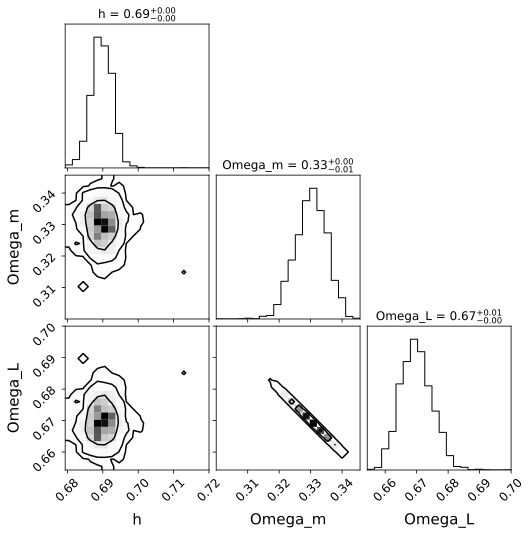

In [170]:
# # to simply plot the MCMC points, uncomment the line below
# plt.plot(a,b,'ko',ms=0.1)

# combine the two arrays into a single one
combined = np.vstack((a,b,c)).T

# uncomment the line below for a corner plot
figure = corner.corner(combined, labels=["h", "Omega_m","Omega_L"],
                       levels=[0.683,0.954,0.997],
                       plot_datapoints=False,
                       plot_density=True,
                       plot_contours=True,
                       show_titles=True, title_kwargs={"fontsize": 12})

plt.show()